<div align="center">
  <h1>Predictions using Gaussian Proccesses and Bayesian Models</h1>
  <br>
  <b>Lyla Fadden, Filip Piasevoli, Aaron Zampaglione</b>
  <br>
  <i>Pavlos Protopapas</i>
  <br>
  https://github.com/azampagl/gp-and-bayesian-predictions
  <br>
  http://azampagl.github.io/gp-and-bayesian-predictions/
</div>

*****

## Background/Motivation ##
We are members of a four-person team of Harvard students working alongside MBTA staff to analyze and better predict demand for public transportation. The primary goal of that project is a machine learning model to predict subway demand, accounting for recent past ridership, seasonal/cyclical effects, and sporadic events like severe weather and major events. 

### Problem Definition ###

We’ve built predictive models for MBTA ridership as part of our Capstone project, but even with two years worth of data, we’ve run into several problems when building models. One model looks to predict the change in ridership for a particular station as a function of the amount of snowfall. Snowfall, however, occurs in greater frequency for amounts of 0-3 inches than it does for greater amounts of snow like 6-10 inches. Further, there seems to be much more noise in ridership for days with low amounts of snow, possibly due to inaccurate forecasts, school closings, service delays, or other extraneous factors. A simple linear model seems too rigid and does not do a good job of imputing values for unobserved amounts of snowfall. We hope to use Gaussian Processes to better model the effect of snowfall on ridership as it considers the span of all gaussian fits constrained by the relatively low amount of days we do observe with snow.

Secondly, we look to predict the general ridership of a station on any particular day as a function of historical ridership as well as other external factors like the weather or public events. Currently, we use the predictors to build a linear model, but it suffers from overfitting to station closures, holidays, and general outliers. We hope to use both Gaussian Processes and Bayesian Linear regression to create two alternative models to which we can compare our simple linear model fit by OLS.

### Questions to Address ###

- How much can we improve our predictive accuracy by implementing stochastic methods in building our models?
- Are these stochastic methods more resilient to outliers and missing data?

### Methodology ###

- In the case of modeling ridership as a function of snowfall, we will use Gaussian Processes to create a model that incorporates the variance at individual levels of snowfall and incorporates a more dynamic range of predicted values for snowfall levels that were observed.
- We will use a Bayesian Linear Regression framework, similar to the last problem in HW7, in order to estimate the parameters of the linear models to predict ridership. We will also use Gaussian Processes in a Time Series scope to see if it improves the predictive power compared to our simple linear model.

### Data ###

- We have two years worth of MBTA entries data aggregated at 15-minute intervals for each station.
- We also have the amount of snowfall data from NOAA for each day appearing in the aforementioned data set.

In [1]:
import matplotlib, matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import pymc

import sklearn
from sklearn import cross_validation, grid_search
from sklearn import linear_model

sns.set_style("whitegrid")
sns.set_context("paper")
% matplotlib inline

## Bayesian Linear Prediction ##





**Prior 1 (Flat priors)** 

$$p(\beta_0,\beta,\sigma^2)\propto 1/\sigma^2.$$

**Prior 2 ('Conjugate' priors)** 

$$\beta_0\sim\mathcal{N}(0.0, 0.5^2),\beta\sim\mathcal{N}(0.0, 0.5^2),\sigma^2\sim Inv-\chi^2(\nu, s^2).$$

** normal noise**

If we assume $\epsilon_i$ are i.i.d. Gaussian instead of i.i.d. t, the likelihood function is given by

$$p(y_1,\ldots, y_n|\beta_0,\beta,\sigma^2)\propto \frac{1}{\sigma^n}\exp(-\frac{\sum_{i=1}^n (y_i-\beta_0-\beta x_i)^2}{2\sigma^2}),$$

which can be simplified as

$$p(y_1,\ldots, y_n|\beta_0,\beta,\sigma^2)\propto \frac{1}{\sigma^{n}}\exp(-\frac{n (\beta_0^2 + \beta^2 S_{X}^2 + 2\beta_0\beta \bar{X} - 2\beta_0 \bar{Y} - 2\beta S_{XY}+S_Y^2)}{2\sigma^2}).$$

** t distribution noise**

If we assume $\epsilon_i$ are i.i.d. t distribution with degree of freedom $\nu$, the likelihood function is given by

$$p(y_1,\ldots, y_n|\beta_0,\beta,\sigma^2)\propto \frac{1}{\sigma^n}\prod_{i=1}^n (1+\frac{(y_i-\beta_0-x_i\beta_1)^2}{\sigma^2\nu})^{-\frac{\nu+1}{2}}.$$



In [2]:
data = pd.read_csv('../data/mbta_daily_weather_games_grouping_noholidays_weekdays.csv', low_memory=False).reset_index(drop=True)
data.head()

,locationid,service_day,entries,name,line_1,line_2,lat,lon,service_datetime,fog,...,snow_accum,snow_accum_predict,dist_to_center,entries_weeks_ago_1,entries_weeks_ago_2,entries_weeks_ago_3,bruins_game,celtics_game,sox_game,grouping
0,1002,2013-01-03 00:00:00,5733,Andrew Square,Red,NaN,42.32955,-71.05696,2013-01-03 05:00:00,0,...,0,0,3.404767,NaN,NaN,NaN,0,0,0,2
1,1002,2013-01-04 00:00:00,6125,Andrew Square,Red,NaN,42.32955,-71.05696,2013-01-04 05:00:00,0,...,0,0,3.404767,NaN,NaN,NaN,0,1,0,2
2,1002,2013-01-07 00:00:00,5998,Andrew Square,Red,NaN,42.32955,-71.05696,2013-01-07 04:00:00,0,...,0,0,3.404767,NaN,NaN,NaN,0,0,0,2
3,1002,2013-01-08 00:00:00,6002,Andrew Square,Red,NaN,42.32955,-71.05696,2013-01-08 04:30:00,0,...,0,0,3.404767,NaN,NaN,NaN,0,0,0,2
4,1002,2013-01-09 00:00:00,6055,Andrew Square,Red,NaN,42.32955,-71.05696,2013-01-09 04:45:00,0,...,0,0,3.404767,NaN,NaN,NaN,0,1,0,2


In [3]:
station = data[data['locationid'] == 1052]
station.head()

,locationid,service_day,entries,name,line_1,line_2,lat,lon,service_datetime,fog,...,snow_accum,snow_accum_predict,dist_to_center,entries_weeks_ago_1,entries_weeks_ago_2,entries_weeks_ago_3,bruins_game,celtics_game,sox_game,grouping
14782,1052,2013-01-03 00:00:00,14210,Park Street,Green,Red,42.356197,-71.062295,2013-01-03 03:00:00,0,...,0,0,0.575981,NaN,NaN,NaN,0,0,0,0
14783,1052,2013-01-04 00:00:00,16292,Park Street,Green,Red,42.356197,-71.062295,2013-01-04 03:45:00,0,...,0,0,0.575981,NaN,NaN,NaN,0,1,0,0
14784,1052,2013-01-07 00:00:00,14675,Park Street,Green,Red,42.356197,-71.062295,2013-01-07 03:45:00,0,...,0,0,0.575981,NaN,NaN,NaN,0,0,0,0
14785,1052,2013-01-08 00:00:00,15935,Park Street,Green,Red,42.356197,-71.062295,2013-01-08 03:45:00,0,...,0,0,0.575981,NaN,NaN,NaN,0,0,0,0
14786,1052,2013-01-09 00:00:00,16005,Park Street,Green,Red,42.356197,-71.062295,2013-01-09 03:00:00,0,...,0,0,0.575981,NaN,NaN,NaN,0,1,0,0


In [212]:
features = ['entries_weeks_ago_1', 'entries_weeks_ago_2', 'entries_weeks_ago_3', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'snow', 'snow_fall', 'snow_accum', 'bruins_game', 'celtics_game', 'sox_game']

# Only look at rows in which we have values.
ix = (pd.notnull(station['entries_weeks_ago_1']).values) & \
     (pd.notnull(station['entries_weeks_ago_2']).values) & \
     (pd.notnull(station['entries_weeks_ago_3']).values)

Y = station[ix]['entries'].values
X = station[ix][features].values

print(len(Y))
print(len(X))

508
508


In [10]:
"""
Flat log prior.
"""
logprior_flat = lambda betas, sig: -2 * np.log(sig)

In [70]:
"""
Log likelihood for the normal distribution.
"""
loglikelihood_n = lambda betas, sig: (-len(y) * np.log(sig)) - (np.sum(np.power(np.array([y[i] - np.sum(betas * x[i]) for i in xrange(len(y))]), 2)) / (2.0 * sig ** 2))

In [98]:
"""
Metropolis Hastings

Key arguments:
logprior      -- The log prior function to use.
loglikelihood -- The log prior function to use.
n             -- The number of samples.
p0            -- The initial "position" (an array of beta0, beta1, sig).
step          -- The stepping sizes (an array of steps for beta0, beta1, sig).
"""
def mh(logprior, loglikelihood, n, p0, step):
    # Determine the number of variables to sample for.
    v = len(p0)
    
    samples = np.zeros((n + 1, v))
    
    # Initialize our first choice.
    samples[0] = p0
    
    accepted = 0
    
    for i in xrange(n / v):
        for j in xrange(v):
            # Get the current sample index
            ix = i * v + j
            
            p_prev = samples[ix]
        
            # Randomly shift the next values.
            p_next = p_prev.copy()
            p_next[j] = p_next[j] + np.random.normal(0, step[j])
        
            # Determine random comparison.
            u = np.log(np.random.uniform())

            # Only calculate a if sig > 0.
            a = -np.inf
            if (p_next[2] > 0.0):
                a_next = logprior(p_next[0:-1], p_next[-1]) + loglikelihood(p_next[0:-1], p_next[-1])
                a_prev = logprior(p_prev[0:-1], p_prev[-1]) + loglikelihood(p_prev[0:-1], p_prev[-1])
                a = a_next - a_prev

            # See if we accept the new value.
            if u < a:
                samples[ix + 1] = p_next
                accepted += 1
            else:
                samples[ix + 1] = p_prev
    
    return samples[:-v], accepted / float(n)

In [182]:
# The number of samples.
n = 100000
# Get the number of features plus sigma, which will also be the number of betas
f = len(features) + 1

starts = [
    0.3, # entries_weeks_ago_1
    0.3, # entries_weeks_ago_2
    0.3, # entries_weeks_ago_3
    0.0, # month_1
    0.0, # month_2
    0.0, # month_3
    0.0, # month_4
    0.0, # month_5
    0.0, # month_6
    0.0, # month_7
    0.0, # month_8
    0.0, # month_9
    0.0, # month_10
    0.0, # month_11
    0.0, # month_12
    0.0, # snow
    0.0, # snow_fall
    0.0, # snow_accum
    0.0, # bruins_game
    0.0, # celtics_game
    0.0, # sox_game
    1.0, # sig
]

steps = [
    0.01, # entries_weeks_ago_1
    0.01, # entries_weeks_ago_2
    0.01, # entries_weeks_ago_3
    10.0, # month_1
    10.0, # month_2
    10.0, # month_3
    10.0, # month_4
    10.0, # month_5
    10.0, # month_6
    10.0, # month_7
    10.0, # month_8
    10.0, # month_9
    10.0, # month_10
    10.0, # month_11
    10.0, # month_12
    10.0, # snow
    10.0, # snow_fall
    10.0, # snow_accum
    10.0, # bruins_game
    10.0, # celtics_game
    10.0, # sox_game
    100.0,# sig
]

# Start sampling.
samples_flat_n, ar = mh(logprior_flat, loglikelihood_n, n, starts, steps)
print(ar)

0.84525


In [229]:
np.savetxt("andrew_square-samples_flat_n.csv", samples_flat_n, delimiter=",")

In [3]:
samples_flat_n = np.loadtxt("andrew_square-samples_flat_n.csv")

ValueError: invalid literal for float(): 2.999999999999999889e-01,2.999999999999999889e-01,2.999999999999999889e-01,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,0.000000000000000000e+00,

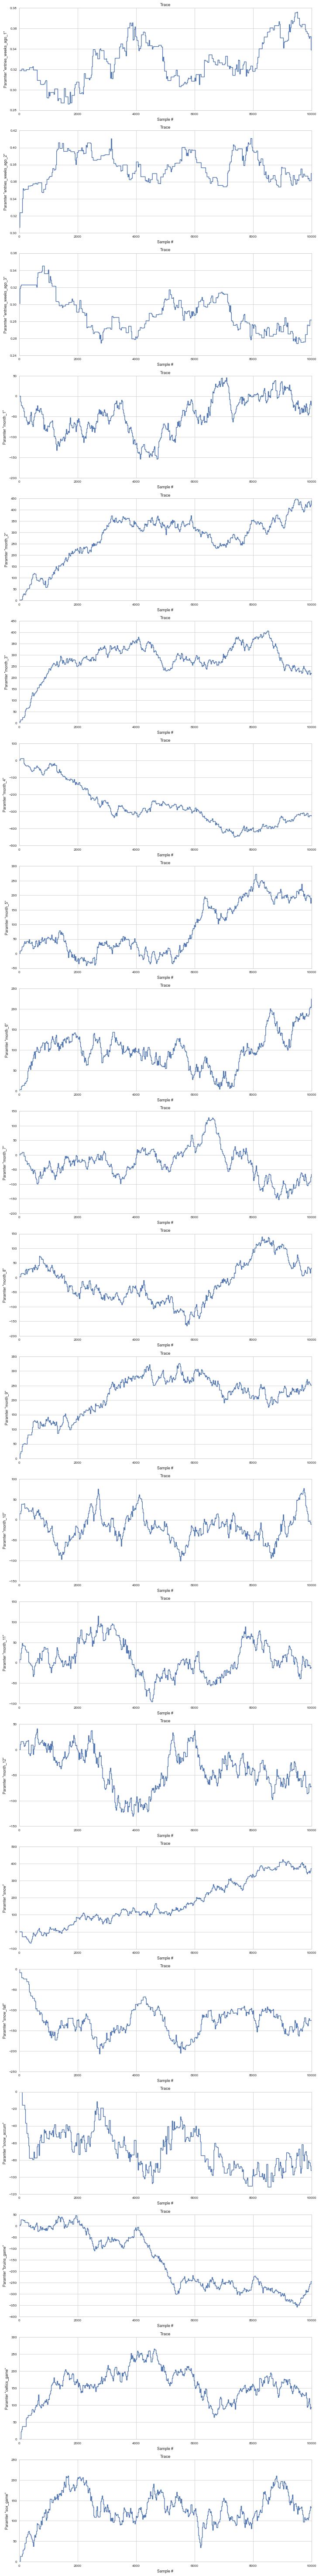

In [183]:
n = 10000
plt.figure(figsize=(12, f * 5))

for i in xrange(f - 1):
    plt.subplot(f, 1, i + 1)
    plt.plot(samples_flat_n[:,i][:n])
    plt.xlabel('Sample #')
    plt.ylabel('Paramter "' + features[i] +'"')
    plt.title('Trace')

plt.show()

In [218]:
burnin = 50000

samples_flat_n_clean = [None] * f

for i in xrange(f):
    samples_flat_n_clean[i] = samples_flat_n[:,i][burnin:][::10]

print(samples_flat_n[:,10])
print(samples_flat_n_clean[10])

[   0.            0.            0.         ...,  211.59104504  211.59104504
  211.59104504]
[ 136.76919537  136.76919537  135.77615424 ...,  220.37593184  211.59104504
  211.59104504]


In [219]:
for i in xrange(f - 1):
    print("Parameter " + features[i] + ": " + str(np.mean(samples_flat_n_clean[i])))

Parameter entries_weeks_ago_1: 0.256500442963
Parameter entries_weeks_ago_2: 0.373875831399
Parameter entries_weeks_ago_3: 0.325121630715
Parameter month_1: 60.5158089989
Parameter month_2: 468.100025089
Parameter month_3: 432.484568398
Parameter month_4: 77.8556878408
Parameter month_5: 267.884376661
Parameter month_6: 326.570505779
Parameter month_7: 44.4105414294
Parameter month_8: 243.111458202
Parameter month_9: 561.286992002
Parameter month_10: 257.444191833
Parameter month_11: 49.5818082977
Parameter month_12: 142.779836958
Parameter snow: 157.506711482
Parameter snow_fall: -148.43125994
Parameter snow_accum: -60.6095260685
Parameter bruins_game: -17.3768065006
Parameter celtics_game: 291.831176478
Parameter sox_game: 91.8556595519


In [220]:
betas = np.mean(samples_flat_n_clean, axis=1)
sig = betas[-1]
betas = betas[:-1]

In [221]:
print(y[0])
print(x[0])
print(np.sum(x[0] * betas))

5528
[  6.23100000e+03   5.94000000e+03   5.73300000e+03   1.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   5.00000000e-01   0.00000000e+00   1.00000000e+00
   0.00000000e+00]
6005.04122995


In [213]:
betas = []
for i, feature in enumerate(features):
    betas.append(pymc.Normal(feature, mu=0, tau=1.0))

In [214]:
@pymc.deterministic
def y_hat(betas=betas, X=X):
    return X.dot(np.array(betas))

In [216]:
Y_hat = pymc.Normal('Y_hat', mu=y_hat, tau=1.0, value=Y, observed=True)

In [217]:
distributions = [Y_hat] + betas

In [218]:
model = pymc.Model(distributions)
model_map = pymc.MAP(model)
model_map.fit()

 [-----------------100%-----------------] 50000 of 50000 complete in 84.9 secPlotting snow_fall
Plotting month_10
Plotting month_2
Plotting entries_weeks_ago_2
Plotting snow
Plotting month_8
Plotting snow_accum
Plotting month_3
Plotting month_1
Plotting month_5
Plotting month_9
Plotting entries_weeks_ago_3
Plotting month_12
Plotting month_11
Plotting sox_game
Plotting bruins_game
Plotting month_7
Plotting month_6
Plotting celtics_game
Plotting entries_weeks_ago_1
Plotting month_4


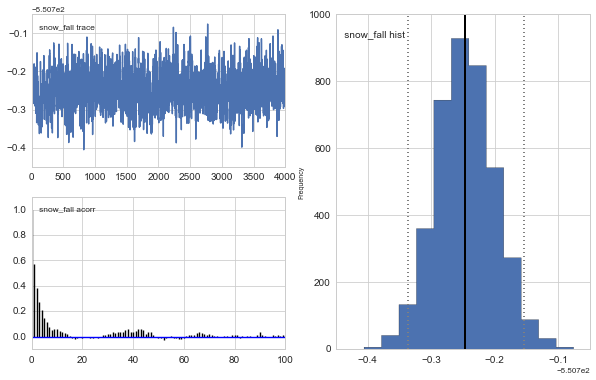

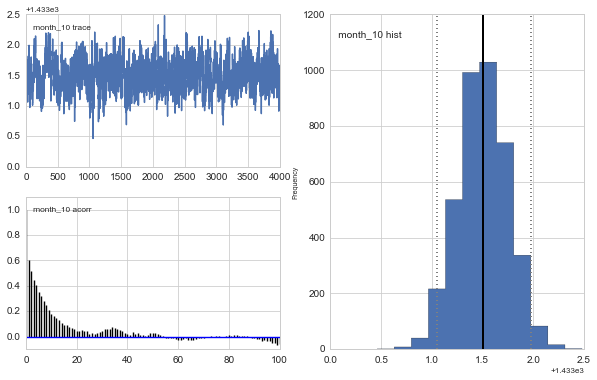

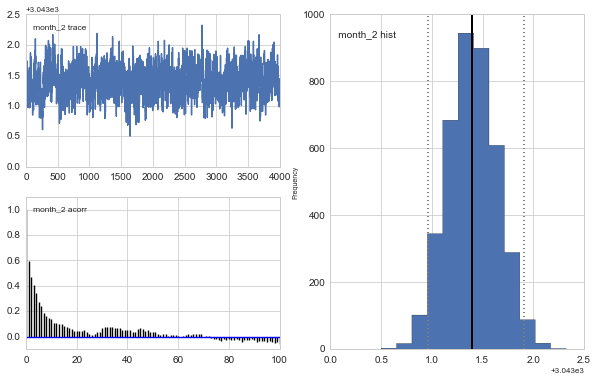

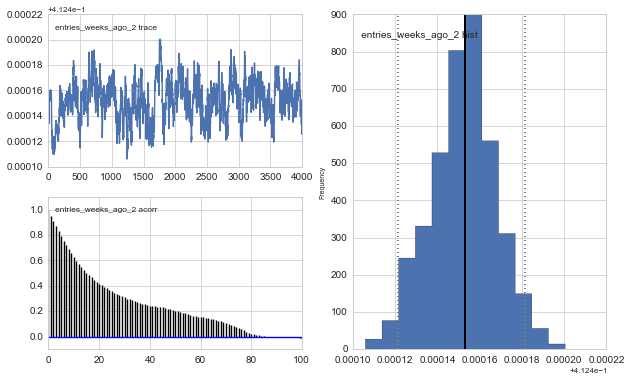

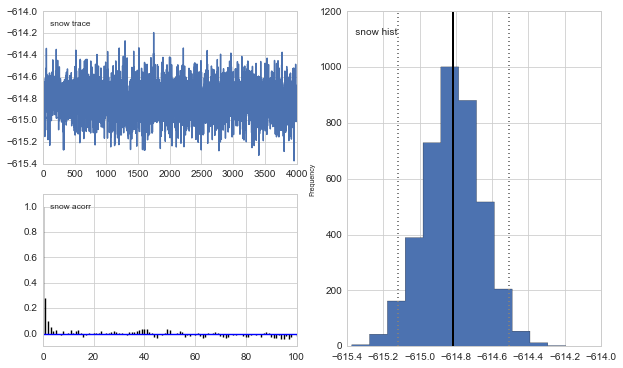

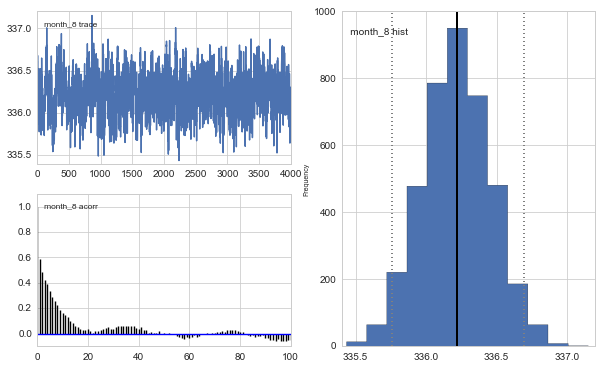

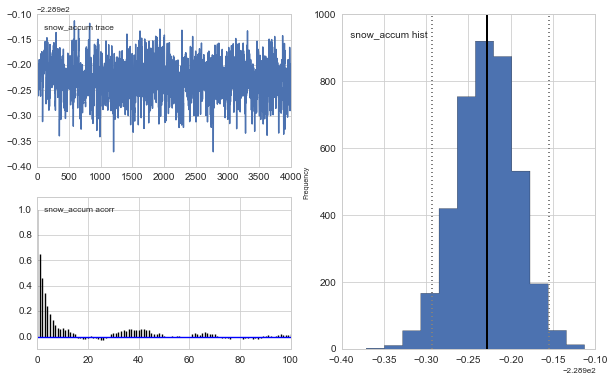

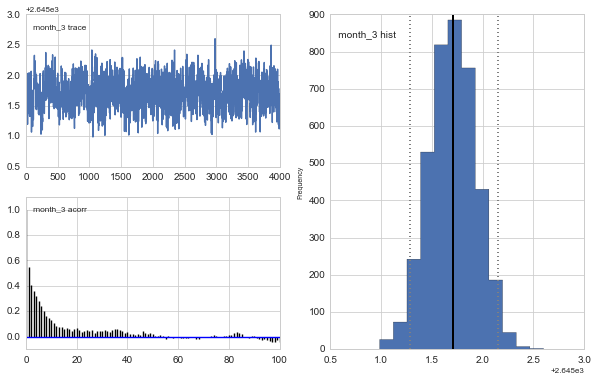

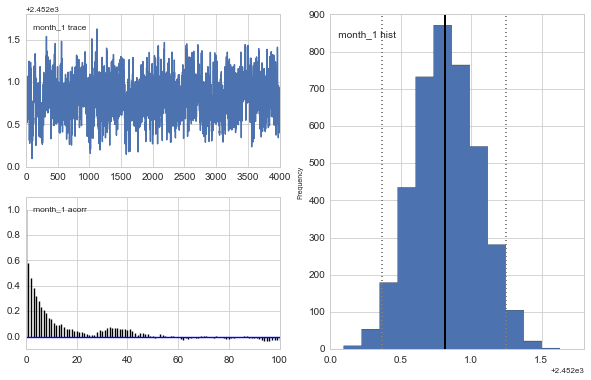

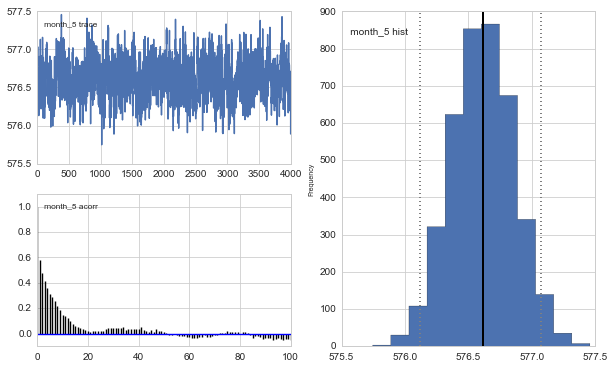

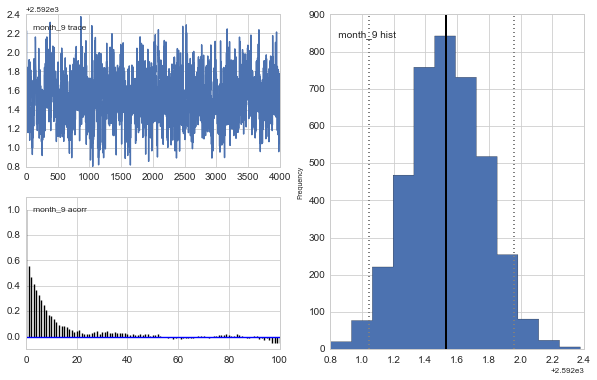

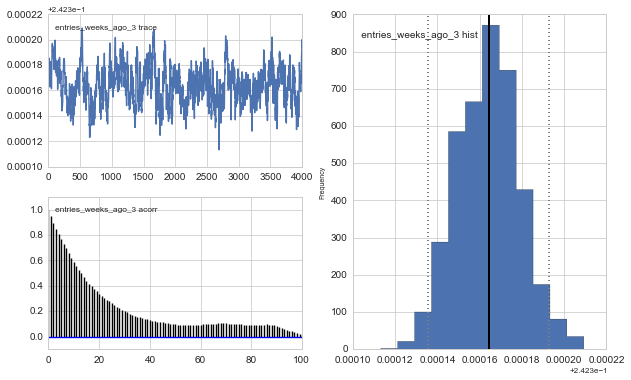

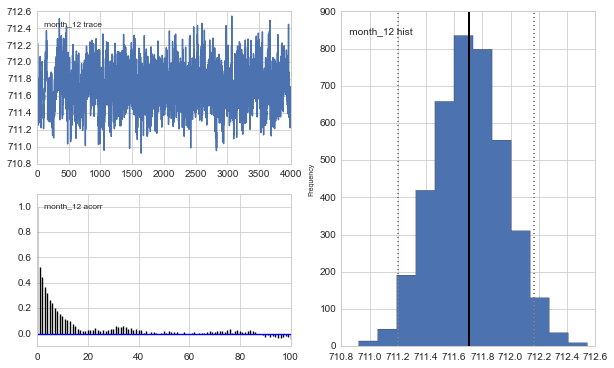

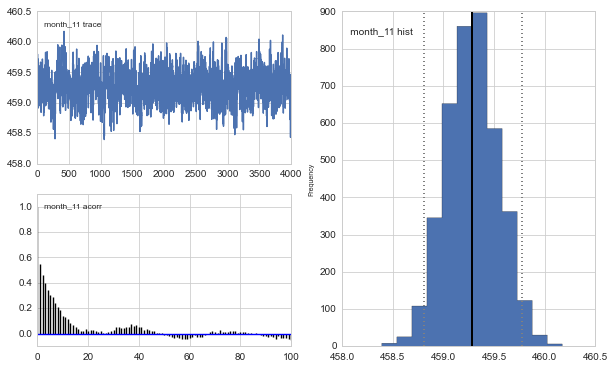

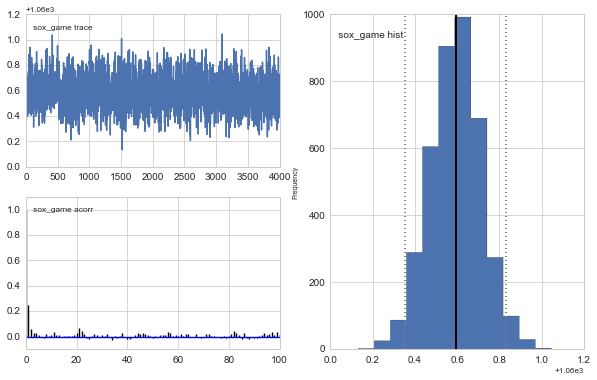

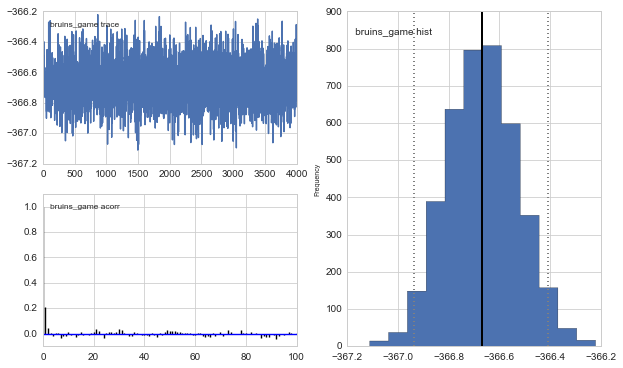

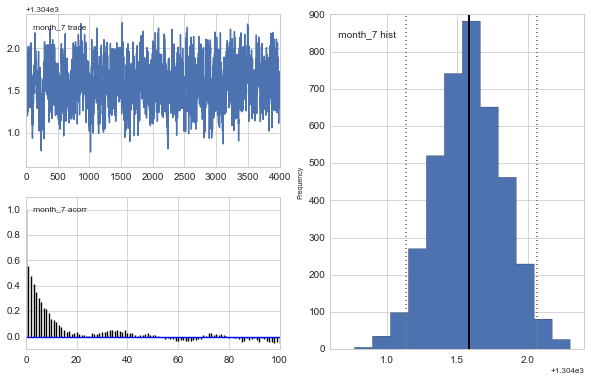

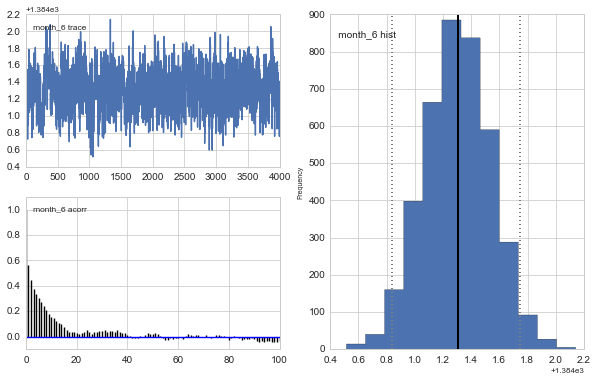

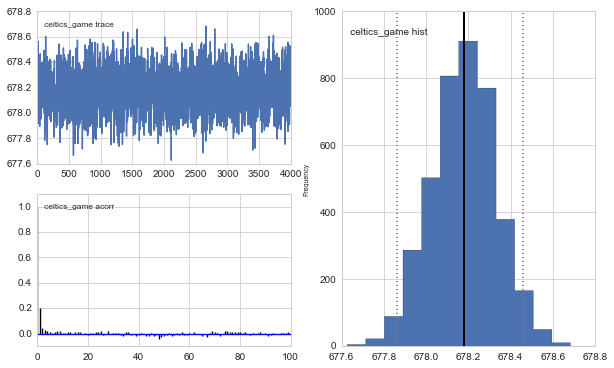

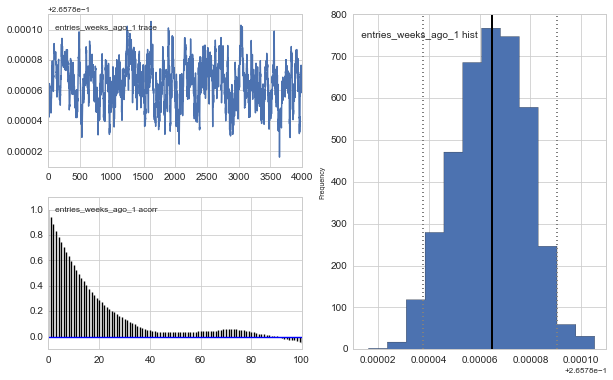

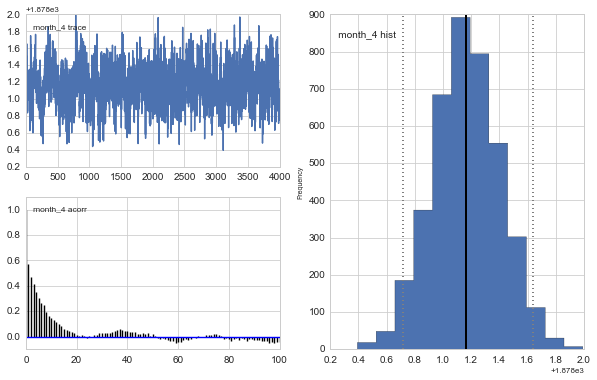

In [219]:
for key in model_map.__dict__.keys():
    if not isinstance(key, basestring):
        del model_map.__dict__[key]

model_mcmc = pymc.MCMC(model_map)
model_mcmc.sample(50000, 10000, 10)

pymc.Matplot.plot(model_mcmc)

In [220]:
coefficients = []
for feature in features:
    trace = model_mcmc.trace(feature)[:]
    beta = trace.mean()
    print(feature + ": " + str(beta))
    coefficients.append(beta)

entries_weeks_ago_1: 0.265844435037
entries_weeks_ago_2: 0.412552348832
entries_weeks_ago_3: 0.242464075491
month_1: 2452.82455208
month_2: 3044.39998116
month_3: 2646.70633313
month_4: 1879.16436817
month_5: 576.612472379
month_6: 1385.30210106
month_7: 1305.58541286
month_8: 336.216848382
month_9: 2593.53195335
month_10: 1434.50551283
month_11: 459.283021774
month_12: 711.709216692
snow: -614.818119977
snow_fall: -550.945832675
snow_accum: -229.128652521
bruins_game: -366.667230399
celtics_game: 678.179597393
sox_game: 1060.59358228


In [221]:
"""
"""
def predict(y, x, betas, rstate):
    # Split the data set into a train and test.
    x_train, x_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size=0.3, random_state=rstate)
    
    # Train using a grid search based on the parameters provided.
    clf = grid_search.GridSearchCV(linear_model.LinearRegression(), {}, scoring='mean_squared_error', cv=10)
    clf.fit(x_train, y_train)
    
    # Determine what the best model was.
    model = clf.best_estimator_
    
    y_pred_lsr = model.predict(x_test)
    error_lsr = np.sum(np.abs(y_pred_lsr - y_test)) / np.sum(y_test)
    
    y_pred_blr = np.array([np.sum(betas * x_test[i]) for i in xrange(len(x_test))])
    error_bsr = np.sum(np.abs(y_pred_blr - y_test)) / np.sum(y_test)
    
    return error_lsr, error_bsr

In [230]:
results = []
for rstate in xrange(50):
    results.append(predict(Y, X, coefficients, rstate=rstate))
    
print(np.mean(results, axis=0))

[ 0.10812531  0.10147199]
